<a href="https://colab.research.google.com/github/lollipop6370/ML2021/blob/main/hw12_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 12 - Reinforcement Learning

# 前置作業
首先我們需要安裝必要的系統套件及 PyPi 套件。 gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。 而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [1]:
!apt update
!apt install python3-opengl xvfb -y
!pip uninstall box2d box2d-py -y
!pip install swig
!pip install box2d-py==2.3.8
!pip install gymnasium[box2d] --no-deps
!pip install pyvirtualdisplay tqdm numpy torch

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,340 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,561 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd

接下來，設置好 virtual display，並引入所有必要的套件。

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

請不要更改 random seed !!!!

In [3]:
seed = 543 # Do not change this
def fix(env, seed):
  obs, info = env.reset(seed=seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

最後，引入 OpenAI 的 gym，並建立一個 Lunar Lander 環境。

In [4]:
%%capture
import gymnasium as gym
import random
import numpy as np

env = gym.make('LunarLander-v3', render_mode="rgb_array")

fix(env, seed)

import time
start = time.time()

In [5]:
!pip freeze

absl-py==1.4.0
accelerate==1.7.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.16.0.38.47
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.6.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.4.0
bokeh==3.7.3
Bottleneck==1.4.2
box2d-py==2.3.8
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.6.15
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake=

# 什麼是 Lunar Lander？
“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。 這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。

> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector.

所謂的「環境」其實同時包括了 agent 和 environment。 我們利用 step() 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

# Observation / State
首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [6]:
print(env.observation_space)

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

# Action
而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [7]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：

- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。 在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。 而這個函式同時會回傳「環境」最初始的狀態。

In [8]:
initial_observation, info = env.reset(seed=seed)
print(initial_observation)

[-1.2619973e-03  1.3984586e+00 -1.2784091e-01 -5.5384123e-01
  1.4691149e-03  2.8957864e-02  0.0000000e+00  0.0000000e+00]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [9]:
random_action = env.action_space.sample()
print(random_action)

3


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。 而這個函式會回傳四項資訊：

- observation / state
- reward
- 自然完成
- 超時或中斷
- 其餘資訊

In [10]:
observation, reward, terminated, truncated, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。 而第三項資訊 `terminated` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [11]:
print(terminated)

False


# Reward
而「環境」給予的 reward 大致是這樣計算：

- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame.

In [12]:
print(reward) # after doing a random action (0), the immediate reward is stored in this

-1.0511407416545058


# Random Agent
最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

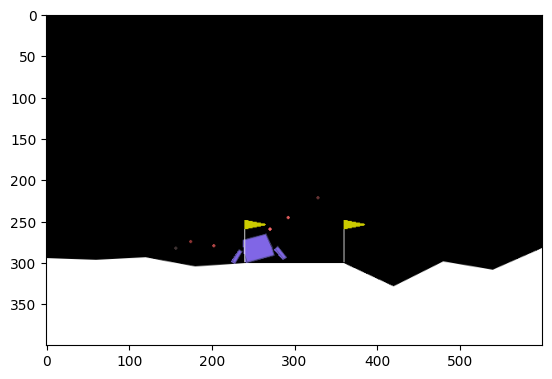

In [13]:
env.reset(seed=seed)

img = plt.imshow(env.render())

terminated = False
while not terminated:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, _ = env.step(action)

    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Policy Gradient
現在來搭建一個簡單的 policy network。 我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [46]:
class MyReinforcementNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.Softmax(dim=-1)
        )

    def forward(self, observation):
        action = self.net(observation)
        return action

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。 這個 agent 能做到以下幾件事：

- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。 而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [47]:
class MyAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        self.optimizer.zero_grad()
        loss = (-log_probs * rewards).sum()
        loss.backward()
        self.optimizer.step()

    def sample(self, observation):
        action_prob = self.network(torch.tensor(observation))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

最後，建立一個 network 和 agent，就可以開始進行訓練了

In [48]:
reinforcement_network = MyReinforcementNetwork()
agent = MyAgent(reinforcement_network)

# 訓練 Agent
現在我們開始訓練 agent。 透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [50]:
agent.network.train()
EPISODE_PER_BATCH = 5
NUM_BATCH = 400
GAMMA = 0.99

avg_total_rewards = []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs = []
    rewards = []

    for episode in range(EPISODE_PER_BATCH):

        one_episode_reward = []
        observation, _ = env.reset(seed=seed)
        total_step = 0

        while True:
            action, log_prob = agent.sample(observation)
            observation, reward, terminated, truncated, _ = env.step(action)
            log_probs.append(log_prob)
            one_episode_reward.append(reward)
            #total_reward += reward
            total_step += 1

            done = terminated or truncated
            if done:
                weighted_reward = 0
                final_reward = []
                for r in reversed(one_episode_reward):
                    weighted_reward = GAMMA * weighted_reward + r
                    final_reward.insert(0, weighted_reward)
                rewards.extend(final_reward)
                break

    #print(f"rewards looks like ", rewards)
    #print(f"log_probs looks like ", log_probs)

    batch_reward = torch.tensor(rewards, dtype=torch.float32)
    batch_log_prob = torch.stack(log_probs)

    # 正規標準化
    batch_reward_mean = batch_reward.mean()
    batch_reward_std = batch_reward.std() + 1e-9
    batch_reward = (batch_reward - batch_reward_mean) / batch_reward_std

    print(f"batch reward mean = ",batch_reward_mean)
    print(f"batch_reward looks like ", batch_reward)
    #print(f"batch_log_prob looks like ", batch_log_prob)
    # update actor network
    agent.learn(batch_log_prob, batch_reward)

  0%|          | 0/400 [00:00<?, ?it/s]

串流輸出內容已截斷至最後 5000 行。
        -0.6785, -0.6346, -0.5881, -0.5384, -0.4803, -0.4204, -0.3577, -0.2866,
        -0.2120, -0.1359, -0.0581,  0.0272,  0.1215,  0.2212,  0.3246,  0.4358,
         0.5467,  0.6596,  0.7814,  0.9051,  1.0397,  1.1749,  1.3197,  1.4647,
         1.6127,  1.7629,  1.9186,  2.0801,  2.2523,  2.4407, -0.7470, -0.7781,
        -0.8109, -0.8330, -0.8500, -0.8654, -0.8776, -0.8877, -0.8930, -0.8940,
        -0.8921, -0.8858, -0.8764, -0.8638, -0.8491, -0.8313, -0.8091, -0.7840,
        -0.7528, -0.7177, -0.6785, -0.6346, -0.5881, -0.5384, -0.4803, -0.4204,
        -0.3577, -0.2866, -0.2120, -0.1359, -0.0581,  0.0272,  0.1215,  0.2212,
         0.3246,  0.4358,  0.5467,  0.6596,  0.7814,  0.9051,  1.0397,  1.1749,
         1.3197,  1.4647,  1.6127,  1.7629,  1.9186,  2.0801,  2.2523,  2.4407,
        -0.7470, -0.7781, -0.8109, -0.8330, -0.8500, -0.8654, -0.8776, -0.8877,
        -0.8930, -0.8940, -0.8921, -0.8858, -0.8764, -0.8638, -0.8491, -0.8313,
        -0.8091, -0

# 訓練結果
訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。 理論上，若是 agent 一直在進步，則所得到的 avg_total_reward 也會持續上升，直至 250 上下。 若將其畫出來則結果如下：